In [1]:
import os
import csv
import glob
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [1]:
import torch
from d2l import torch as d2l

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

I0000 00:00:1704390200.052030  324208 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1704390200.095678  324351 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 530.30.02), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2


# Read an Image

In [3]:
data_dir = os.getcwd()
print(data_dir)

/home/duong/3d


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
# Đường dẫn đến thư mục chứa các tệp ảnh.
media_path = data_dir + '/sleep'
print(os.listdir(media_path))

['cac1808916f4bdaae4e5.jpg', 'aeeb90e80795accbf584.jpg', '6347ca575d2af674af3b.jpg', '94661e0b887623287a67.jpg', '.ipynb_checkpoints', 'cef19703027ea920f06f.jpg', '698d088a9ff734a96de6.jpg', 'c42aa9503f2d9473cd3c.jpg', '9917bd682a15814bd804.jpg', 'd6ccf0f86685cddb9494.jpg', 'bdb2b39a25e78eb9d7f6.jpg', '80f92235b7481c164559.jpg']


Số lượng ảnh trong thư mục '/home/duong/3d/sleep': 11


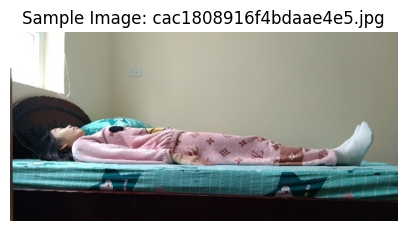

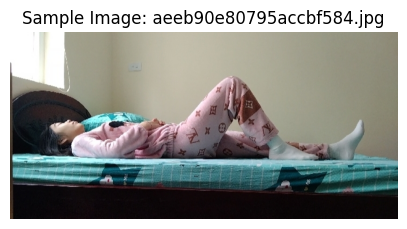

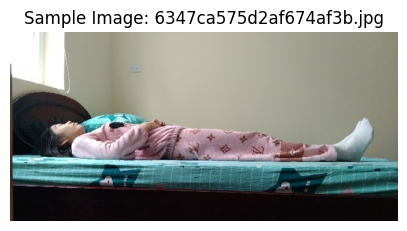

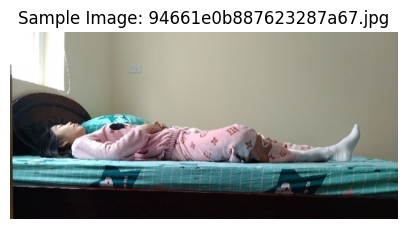

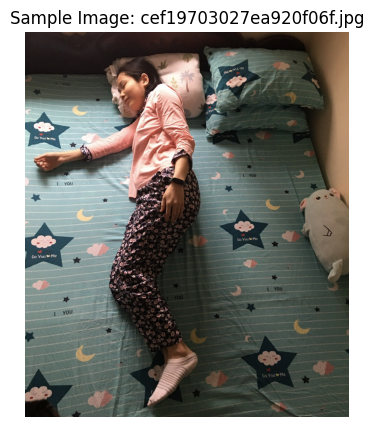

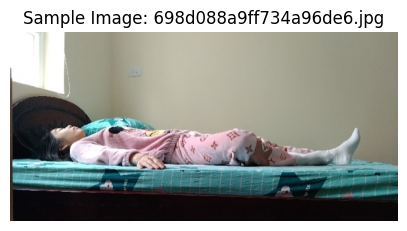

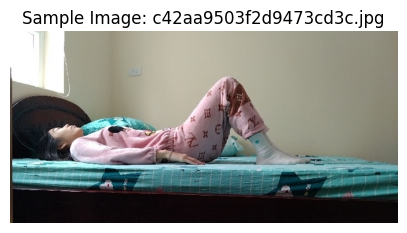

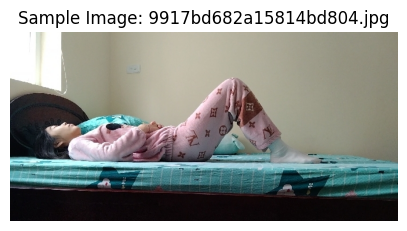

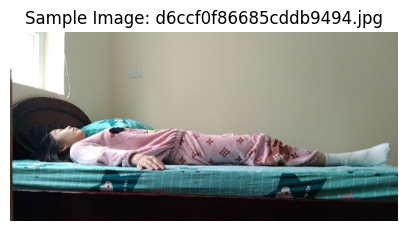

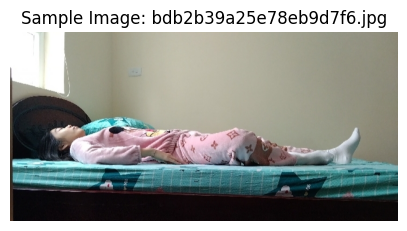

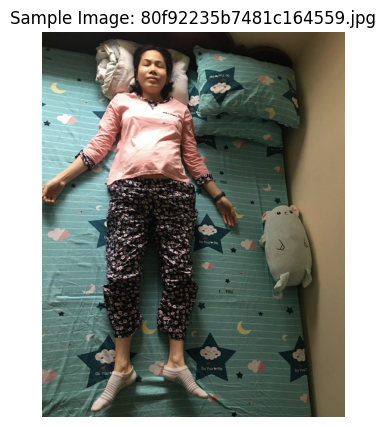

In [5]:
if not os.path.exists(media_path):
    print(f"Thư mục '{media_path}' không tồn tại. Vui lòng kiểm tra lại đường dẫn.")
else:
    # Lấy danh sách tất cả các tệp ảnh trong thư mục.
    image_files = [f for f in os.listdir(media_path) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

    # Số lượng ảnh trong thư mục.
    num_images = len(image_files)
    print(f"Số lượng ảnh trong thư mục '{media_path}': {num_images}")

    # Hiển thị từng ảnh.
    for filename in image_files:
        image_path = os.path.join(media_path, filename)
        sample_img = cv2.imread(image_path)
        
        plt.figure(figsize=[5, 5])
        plt.title("Sample Image: " + filename)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
        plt.show()


In [6]:
# Tạo một file CSV để lưu dữ liệu landmarks.
csv_filename = 'landmarks_data.csv'

In [7]:
# Mở file CSV để ghi dữ liệu.
with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['Image', 'Landmark_Name', 'Landmark_X', 'Landmark_Y', 'Visibility']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    # Lặp qua tất cả các tệp trong thư mục.
    for filename in os.listdir(media_path):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Tạo đường dẫn đầy đủ đến tệp ảnh.
            image_path = os.path.join(media_path, filename)

            # Đọc tệp ảnh.
            sample_img = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

            # Thực hiện pose detection sau khi chuyển ảnh sang định dạng RGB.
            results = pose.process(image_rgb)

            # Kiểm tra nếu có landmarks được tìm thấy.
            if results.pose_landmarks:
                for i, landmark in enumerate(results.pose_landmarks.landmark):
                    # Lấy chiều cao và chiều rộng của ảnh.
                    image_height, image_width, _ = sample_img.shape

                    # Normalize landmarks.
                    normalized_x = landmark.x * image_width
                    normalized_y = landmark.y * image_height

                    # Ghi thông tin landmarks vào file CSV.
                    writer.writerow({
                        'Image': filename,
                        'Landmark_Name': mp_pose.PoseLandmark(i).name,
                        'Landmark_X': landmark.x,
                        'Landmark_Y': landmark.y,
                        'Visibility': landmark.visibility
                    })

In [8]:
csv_dir = data_dir + "/landmarks_data.csv"
landmarks_data = pd.read_csv(csv_dir)
landmarks_data.head()

,Image,Landmark_Name,Landmark_X,Landmark_Y,Visibility
0,aeeb90e80795accbf584.jpg,NOSE,0.144067,0.460882,0.993970
1,aeeb90e80795accbf584.jpg,LEFT_EYE_INNER,0.128575,0.475551,0.982887
2,aeeb90e80795accbf584.jpg,LEFT_EYE,0.128120,0.479310,0.983655
3,aeeb90e80795accbf584.jpg,LEFT_EYE_OUTER,0.127663,0.482773,0.989424
4,aeeb90e80795accbf584.jpg,RIGHT_EYE_INNER,0.127836,0.482565,0.991944


In [9]:
landmarks_data.shape

(330, 5)

In [10]:
landmarks_data.describe()

,Landmark_X,Landmark_Y,Visibility
count,330.000000,330.000000,330.000000
mean,0.360275,0.529318,0.731380
std,0.211372,0.153053,0.382719
min,0.020275,0.090036,0.004671
25%,0.154291,0.494588,0.387748
50%,0.353304,0.540263,0.983771
75%,0.449525,0.608524,0.999263
max,0.866413,0.964496,0.999998


# Create a Pose Detection Function

In [13]:
import cv2
import mediapipe as mp
import math
import matplotlib.pyplot as plt

lmhi_list = []

def detectPose(image, pose, display=True, e=3.236):

    # Create a copy of the input image.
    output_image = image.copy()

    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Pose Detection.
    results = pose.process(imageRGB)

    # Retrieve the height and width of the input image.
    height, width, _ = image.shape

    # Initialize a list to store the detected landmarks.
    landmarks = []

    # Check if any landmarks are detected.
    if results.pose_landmarks:

        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)

        # Initialize variables for calculating height
        x0, y0, x9, y9, x10, y10, x11, y11, x12, y12, x23, y23, x24, y24, x26, y26, x28, y28, x30, y30, x32, y32 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        h5, h1, h2, h3, h4 = 0, 0, 0, 0, 0

        # Iterate over the detected landmarks.
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            if id == 0:
                x0, y0 = int(lm.x * w), int(lm.y * h)
            if id == 9:
                x9, y9 = int(lm.x * w), int(lm.y * h)
            if id == 10:
                x10, y10 = int(lm.x * w), int(lm.y * h)
                h0910 = (((x0 - (x9 + x10) / 2) ** 2 + (y0 - (y9 + y10) / 2) ** 2) ** 0.5)
                h6 = h0910 * 3.236
            if id == 11:
                x11, y11 = int(lm.x * w), int(lm.y * h)
            if id == 12:
                x12, y12 = int(lm.x * w), int(lm.y * h)
                xh5 = ((x11 + x12) / 2) - x0
                yh5 = ((y11 + y12) / 2) - y0
                h5 = (xh5 ** 2 + yh5 ** 2) ** 0.5
            if id == 23:
                x23, y23 = int(lm.x * w), int(lm.y * h)
            if id == 24:
                x24, y24 = int(lm.x * w), int(lm.y * h)
                xh1 = (x23 + x24 - x11 - x12) / 2
                yh1 = (y23 + y24 - y11 - y12) / 2
                h1 = (xh1 ** 2 + yh1 ** 2) ** 0.5
            if id == 26:
                x26, y26 = int(lm.x * w), int(lm.y * h)
                xh2 = (x26 - x24)
                yh2 = (y26 - y24)
                h2 = (xh2 ** 2 + yh2 ** 2) ** 0.5
            if id == 28:
                x28, y28 = int(lm.x * w), int(lm.y * h)
                xh3 = (x28 - x26)
                yh3 = (y28 - y26)
                h3 = (xh3 ** 2 + yh3 ** 2) ** 0.5
            if id == 30:
                x30, y30 = int(lm.x * w), int(lm.y * h)
            if id == 32:
                x32, y32 = int(lm.x * w), int(lm.y * h)
                a = y30 - y32
                b = x32 - x30
                c = -x30 * (y30 - y32) - y30 * (x32 - x30)
                h4 = math.fabs(a * x28 + b * y28 + c) / ((a ** 2 + b ** 2) ** 0.5)

                # Calculate height
                hb = h5 + h1 + h2 + h3 + h4
                hi = round(hb / e, 3)
                lmhi_list.append([h5, h1, h2, h3, h4, hi])
                print([hi, h, w])

            # Append the landmark into the list.
            landmarks.append((int(lm.x * width), int(lm.y * height),
                              (lm.z * width)))

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:

        # Display the original input image and the resultant image.
        plt.figure(figsize=[22, 22])
        plt.subplot(121);
        plt.imshow(image[:, :, ::-1]);
        plt.title("Original Image");
        plt.axis('off');
        plt.subplot(122);
        plt.imshow(output_image[:, :, ::-1]);
        plt.title("Output Image");
        plt.axis('off');

    # Otherwise
    else:

        # Return the output image and the found landmarks.
        return output_image, landmarks